### Dataset:
https://www.kaggle.com/datasets/lorentzyeung/top-240-recommended-restaurants-in-la-2023

In [1127]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import nltk
%matplotlib inline

### 0. Описание задачи

**Top 240 Recommended Restaurants in L.A. 2023**

Датасет представляет собой исчерпывающую информацию о 240 лучших ресторанах, рекомендованных в Лос-Анджелесе, перечисленных на Yelp. Его цель — предоставить ценную информацию о различных аспектах этих ресторанов, таких как отзывы клиентов, звездные рейтинги, стили кухни и многое другое.
Данные были собраны с помощью скрипта Python, который использует методы очистки веб-страниц для извлечения соответствующей информации с веб-сайта Yelp. Идентифицировано 240 ресторанов и получены их URL-адреса.

Для каждого ресторана собираются только последние 10 комментариев/отзывов.
Цель данных состоит в том, чтобы представить недавние результаты работы ресторанов, а не отзывы в целом.

Рассматриваемый датасет содержит следующие признаки
<br>Числовые:
- `Rank` - место в рейтинге
- `StarRating` - средняя оценка посетителей ресторана
- `NumberOfReviews` - Общее количество отзывов у заведения

<br>Категориальные:
- `CommentDate` - дата написания отзыва
- `Date` - дата парсинга
- `Price` - ценовая категория ресторана

<br>Текстовые:
- `RestaurantName` - название ресторана
- `Comment` - содержание отзыва о ресторане
- `Address` - адрес заведения
- `Style` - виды "кухни", предлагаемые рестораном

Всего 10 признаков.<br>
Цель работы с датасетом - предсказание средней оценки ресторана `StarRating` (решение задачи регрессии).


### 1. Чтение данных

In [1128]:
url = 'https://raw.githubusercontent.com/ITrickStar/ML-2023/main/Top240RestaurantsRecommandedInLosAngeles2023.csv'
dataframe = pd.read_csv(url, encoding='utf-8')

In [1129]:
dataframe.head(10)

,Rank,CommentDate,Date,RestaurantName,Comment,Address,StarRating,NumberOfReviews,Style,Price
0,1,2023-09-16,2023-09-17,GRANVILLE,Great ambiance indoors and attentive staff. Re...,"8701 Beverly Blvd West Hollywood, CA 90048",4.4,2672,"American (New), Cocktail Bars",$$
1,1,2023-09-15,2023-09-17,GRANVILLE,Wrong wrong wrong. AIf you don't fit the Ty ...,"8701 Beverly Blvd West Hollywood, CA 90048",4.4,2672,"American (New), Cocktail Bars",$$
2,1,2023-09-07,2023-09-17,GRANVILLE,Bad service!! The worst servers. Marcos the ma...,"8701 Beverly Blvd West Hollywood, CA 90048",4.4,2672,"American (New), Cocktail Bars",$$
3,1,2023-09-06,2023-09-17,GRANVILLE,One of my absolute favorite places in WeHo for...,"8701 Beverly Blvd West Hollywood, CA 90048",4.4,2672,"American (New), Cocktail Bars",$$
4,1,2023-09-05,2023-09-17,GRANVILLE,Always a good experience and food is great.Tea...,"8701 Beverly Blvd West Hollywood, CA 90048",4.4,2672,"American (New), Cocktail Bars",$$
5,1,2023-09-04,2023-09-17,GRANVILLE,"These five stars are for the food, service, an...","8701 Beverly Blvd West Hollywood, CA 90048",4.4,2672,"American (New), Cocktail Bars",$$
6,1,2023-09-03,2023-09-17,GRANVILLE,Visited Granville for a quick lunch and had an...,"8701 Beverly Blvd West Hollywood, CA 90048",4.4,2672,"American (New), Cocktail Bars",$$
7,1,2023-09-03,2023-09-17,GRANVILLE,"Great ambience, generous portions, delicious c...","8701 Beverly Blvd West Hollywood, CA 90048",4.4,2672,"American (New), Cocktail Bars",$$
8,1,2023-08-31,2023-09-17,GRANVILLE,Food was fine. Follow up service was non exist...,"8701 Beverly Blvd West Hollywood, CA 90048",4.4,2672,"American (New), Cocktail Bars",$$
9,1,2023-08-31,2023-09-17,GRANVILLE,The food was fine and the ambiance was nice. O...,"8701 Beverly Blvd West Hollywood, CA 90048",4.4,2672,"American (New), Cocktail Bars",$$


Всего в таблице содержатся данные 2381 комментариев о 235 самых рекомендуемых ресторанах Лос-Анджелеса.

In [1130]:
dataframe.shape

(2381, 10)

In [1131]:
dataframe.columns

Index(['Rank', 'CommentDate', 'Date', 'RestaurantName', 'Comment', 'Address',
       'StarRating', 'NumberOfReviews', 'Style', 'Price'],
      dtype='object')

In [1132]:
len(dataframe["RestaurantName"].unique())

235

### 2. Обработка пропущенных значений

In [1133]:
dataframe.isna().sum()

Rank                 0
CommentDate          0
Date                 0
RestaurantName       0
Comment              0
Address             10
StarRating           0
NumberOfReviews      0
Style                0
Price              636
dtype: int64

`Price` является категориальным признаком, а количество пропущенных значений достаточно велико (около 23%). Заменим пропущенные значения модой.<br>
`Address` является текстовым признаков (сложно заменить), а количество пропущенных значений мало, поэтому проще исключить данные объекты.

In [1134]:
dataframe["Price"].fillna(dataframe["Price"].mode().iloc[0], inplace=True)
dataframe = dataframe.dropna()

In [1135]:
dataframe = dataframe.reset_index(drop=True)
dataframe.isna().sum()

Rank               0
CommentDate        0
Date               0
RestaurantName     0
Comment            0
Address            0
StarRating         0
NumberOfReviews    0
Style              0
Price              0
dtype: int64

### 3. Визуализация данных

Информация о числовых признаках:

In [1136]:
dataframe.describe(include=np.number)

,Rank,StarRating,NumberOfReviews
count,2371.000000,2371.000000,2371.000000
mean,119.697596,4.302573,1145.617883
std,68.679253,0.311749,1533.773278
min,1.000000,3.500000,2.000000
25%,61.000000,4.100000,129.000000
50%,119.000000,4.300000,538.000000
75%,179.000000,4.500000,1623.000000
max,240.000000,5.000000,10020.000000


Можно заметить, что `StarRating` ранжируется от 3.5 до 5.0, при этом среднее значение ~4.3. Можно предположить, что люди склонны оставлять больше положительных комментариев и у ресторанов выше в рейтинге будет больше отзывов.

Информация о категориальных признаках:

In [1137]:
dataframe.describe(include=['O'])

,CommentDate,Date,RestaurantName,Comment,Address,Style,Price
count,2371,2371,2371,2371,2371,2371,2371
unique,200,1,234,2371,233,196,3
top,2023-09-10,2023-09-17,Sun Nong Dan,Great ambiance indoors and attentive staff. Re...,Verified by Business,Korean,$$
freq,128,2371,20,1,29,65,1892


По датам комментариев можно понять, что данные свежие и по ним можно видеть текущее положение ресторанов в ЛА.

Построим графики зависимости числовых переменных:

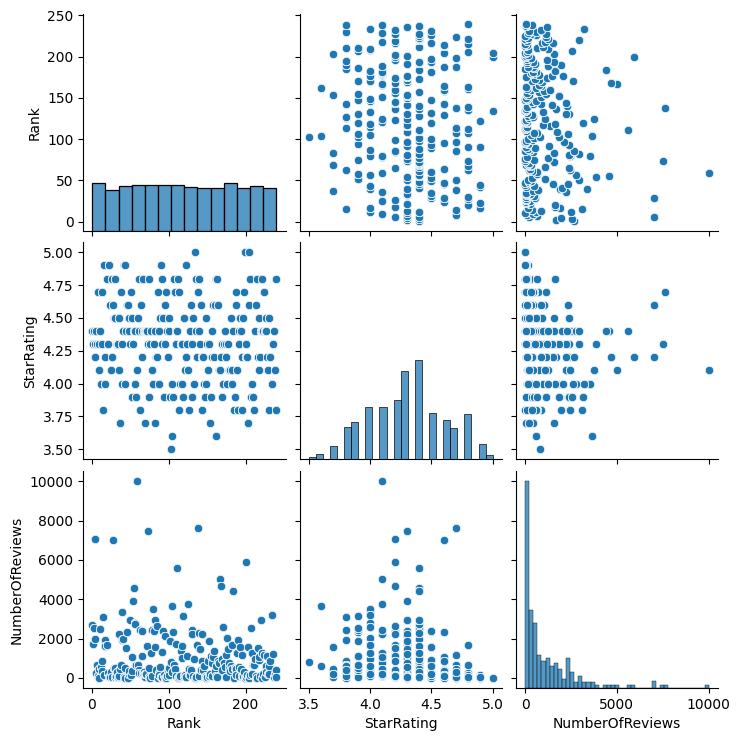

In [1138]:
sns.pairplot(dataframe)

По гистограмме `NumberOfReviews` можно заметить, что лишь некоторые рестораны имеют крупное количество отзывов и большинство из них имеют средний рейтинг.

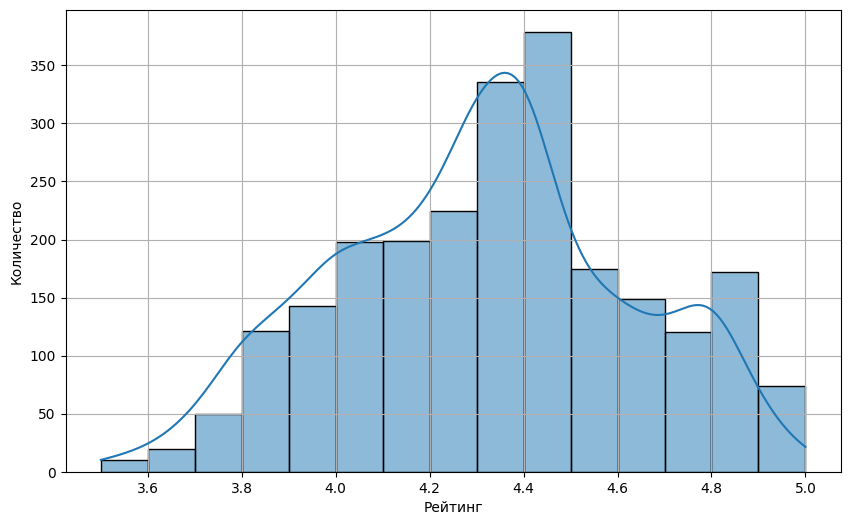

In [1139]:
plt.figure(figsize=(10, 6))
sns.histplot(dataframe['StarRating'], kde=True, bins=15)
plt.xlabel('Рейтинг')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

Распределение рейтинга можно считать нормальным

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anoni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


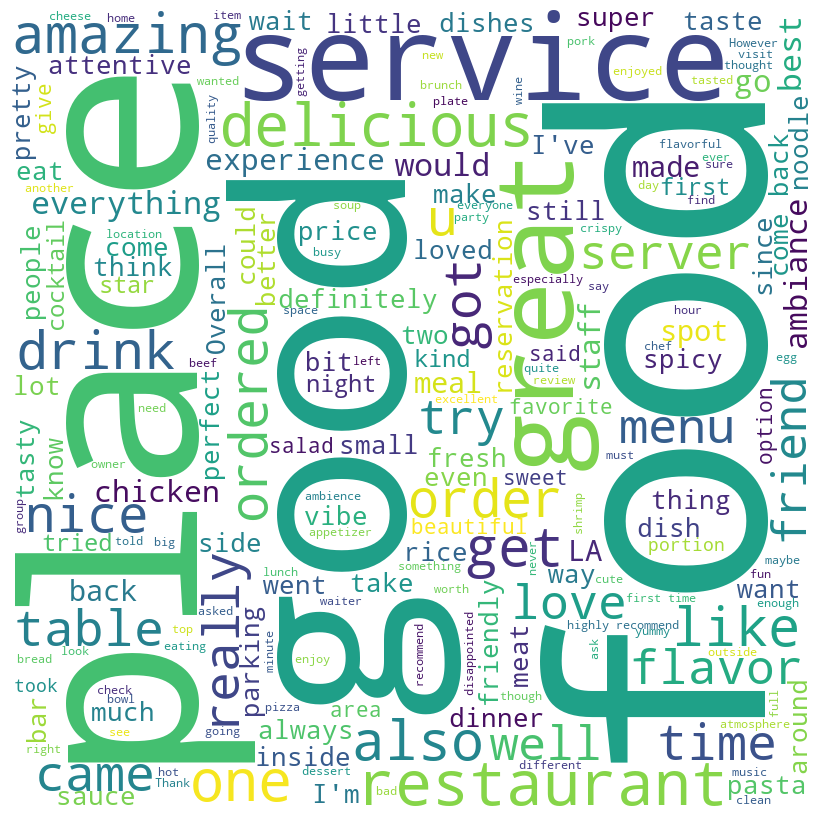

In [1140]:
from wordcloud import WordCloud
nltk.download('stopwords')

text = " ".join(x for x in dataframe["Comment"])
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords=STOPWORDS,
                min_font_size = 10).generate(text)

plt.figure(figsize = (8, 8), facecolor = "white")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

Good и Great являются одними из самыми часто встречающими, это подтверждает, что люди охотнее оставляют положительные отзывы.

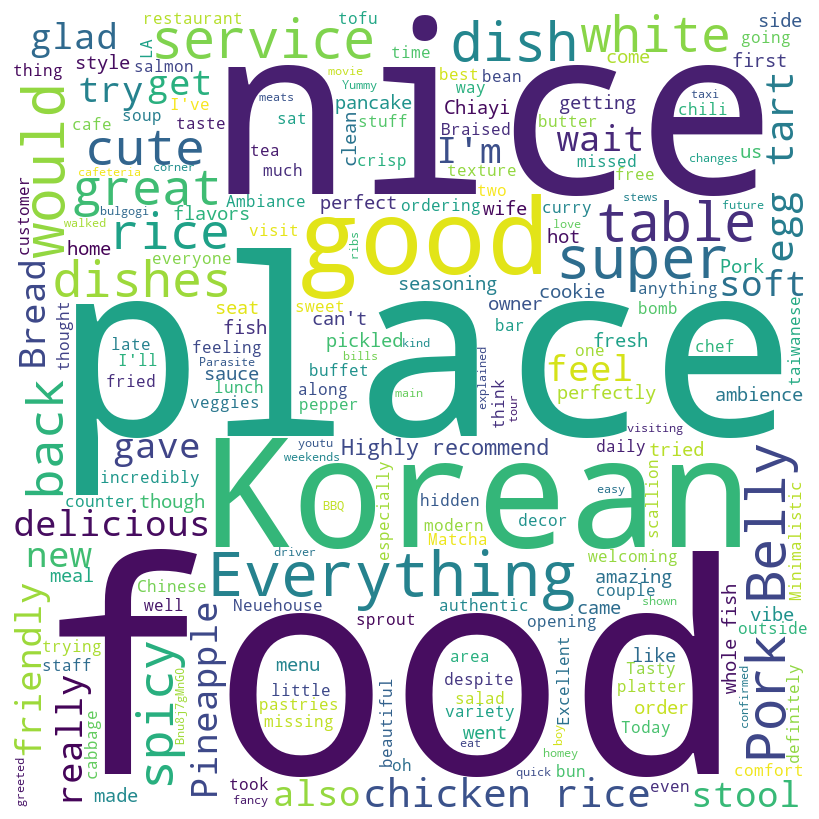

In [1141]:
text = " ".join(x for x in dataframe["Comment"][(dataframe["StarRating"] == 5)])
STOPWORDS = set(stopwords.words('english'))

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords=STOPWORDS,
                min_font_size = 10).generate(text)

plt.figure(figsize = (8, 8), facecolor = "white")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

Среди ресторанов с высокой оценкой чаще упоминаются конкретные блюда, при этом совсем не видно негативных оценок

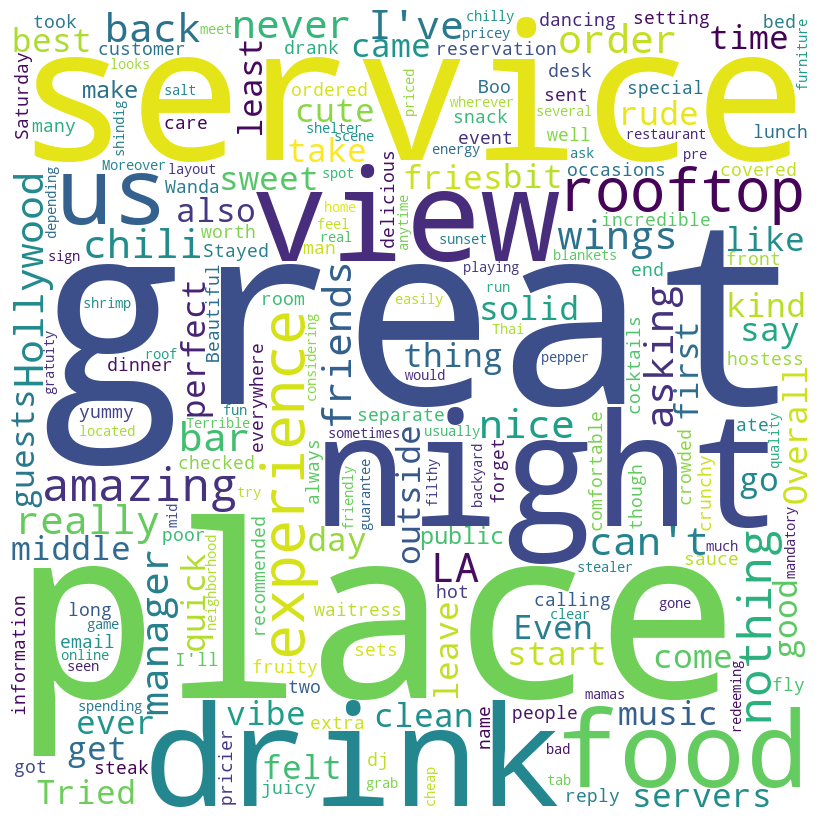

In [1142]:
text = " ".join(x for x in dataframe["Comment"][(dataframe["StarRating"] == 3.5)])
STOPWORDS = set(stopwords.words('english'))

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords=STOPWORDS,
                min_font_size = 10).generate(text)

plt.figure(figsize = (8, 8), facecolor = "white")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

Среди ресторанов с низкой оценкой часто упоминаются напитки и сервис (видимо оставляет желать лучшего), также появляются слова с негативной окраской

In [1143]:
corr_mat = dataframe.corr()
corr_mat

,Rank,StarRating,NumberOfReviews
Rank,1.000000,-0.116539,-0.138835
StarRating,-0.116539,1.000000,-0.173537
NumberOfReviews,-0.138835,-0.173537,1.000000


<AxesSubplot:>

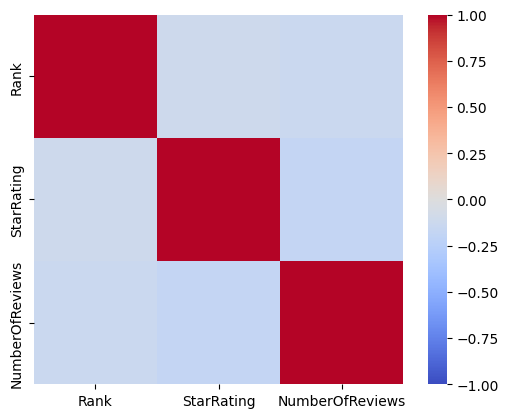

In [1144]:
sns.heatmap(corr_mat, square=True, cmap='coolwarm', vmax=1.0, vmin=-1.0)

Числовые признаки по какой-то причине отрицательно влияют на значения друг друга, но в целом мультиколлинеарность не наблюдается

### 4. Обработка категориальных признаков

In [1145]:
dataframe.describe(include=["object"])

,CommentDate,Date,RestaurantName,Comment,Address,Style,Price
count,2371,2371,2371,2371,2371,2371,2371
unique,200,1,234,2371,233,196,3
top,2023-09-10,2023-09-17,Sun Nong Dan,Great ambiance indoors and attentive staff. Re...,Verified by Business,Korean,$$
freq,128,2371,20,1,29,65,1892


Из "объектных" признаков категориальными являются:
1. `CommentDate`
2. `Date`
3. `Style`
4. `Price`

#### Кодирование `CommentDate`

In [1146]:
import datetime
dataframe["CommentDate"] = dataframe["CommentDate"].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').toordinal())
dataframe["CommentDate"]

0       738779
1       738778
2       738770
3       738769
4       738768
         ...  
2366    738698
2367    738678
2368    738669
2369    738660
2370    738651
Name: CommentDate, Length: 2371, dtype: int64

Не думаю, что дата парсинга должна как то влиять на рейтинг ресторана, поэтому лучше этот признак исключить

In [1147]:
dataframe.drop(["Date"], axis=1, inplace=True)

#### Кодирование `Style`

In [1148]:
data_style = pd.DataFrame(dataframe['Style'].str.split(','))
data_style = data_style.explode('Style', ignore_index=True)
styles = data_style["Style"].unique()

In [1149]:
toconcat = pd.DataFrame()
for style in styles:
    toconcat.insert(0, f"{style}", [0]*len(dataframe))
    for i, data_styles in enumerate(dataframe["Style"]):
        if style in data_styles:
            toconcat[f"{style}"][i] = 1
toconcat

d:\Works\MLlabs\Магистратура\ML_venv\lib\site-packages\IPython\core\interactiveshell.py:3473: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if (await self.run_code(code, result,  async_=asy)):


,Food Stands,Kebab,Wraps,Fast Food,Middle Eastern,Juice Bars & Smoothies,Diners,Barbeque,Argentine,Spanish,...,French,Breakfast & Brunch,Italian,Pizza,Noodles,Korean,Latin American,Gastropubs,Cocktail Bars,American (New)
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2366,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2367,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2368,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2369,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1150]:
dataframe = pd.concat((dataframe, toconcat), axis=1)
dataframe = dataframe.drop(["Style"], axis=1)

По итогу модели все равно получались сложными и я предпринял попытку исключить признаки, которые я считаю высококореллированными

In [1151]:
dataframe.drop(["Rank", "RestaurantName", "Address", "NumberOfReviews"], axis=1, inplace=True)
#dataframe.drop(["Rank", "RestaurantName", "Address"], axis=1, inplace=True)
dataframe.head()

,CommentDate,Comment,StarRating,Price,Food Stands,Kebab,Wraps,Fast Food,Middle Eastern,Juice Bars & Smoothies,...,French,Breakfast & Brunch,Italian,Pizza,Noodles,Korean,Latin American,Gastropubs,Cocktail Bars,American (New)
0,738779,Great ambiance indoors and attentive staff. Re...,4.4,$$,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,738778,Wrong wrong wrong. AIf you don't fit the Ty ...,4.4,$$,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,738770,Bad service!! The worst servers. Marcos the ma...,4.4,$$,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,738769,One of my absolute favorite places in WeHo for...,4.4,$$,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,738768,Always a good experience and food is great.Tea...,4.4,$$,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


#### Кодирование `Price`

In [1152]:
print("Unique values of Price are " + ", ".join(map(str, dataframe["Price"].unique())))

Unique values of Price are $$, $$$, $$$$


In [1153]:
data_nonbinary = pd.get_dummies(dataframe["Price"])
data_nonbinary.head()

,$$,$$$,$$$$
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [1154]:
dataframe = pd.concat((dataframe, data_nonbinary), axis=1)
dataframe = dataframe.drop(["Price"], axis=1)

#### Обработка текстового признака

Определим все необходимые функции

In [1155]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [1156]:
# выделение основы слов (стемминг)
def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [PorterStemmer().stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

# удаление стопслов
def del_stopwords(sentence):
    tokens = sentence.split()
    STOPWORDS = set(stopwords.words("english") + ["also", "one", "even", "get", "got", "go"])
    stemmed_tokens = [word for word in tokens if word not in STOPWORDS]
    return ' '.join(stemmed_tokens)

До:

In [1157]:
data_text = dataframe["Comment"]
print(data_text[1])

Wrong wrong wrong.   AIf you don't fit the Ty as they will escort you out.  Don't drink here.


In [1158]:
# обработка
dataframe["Comment"] = dataframe["Comment"].str.lower()  # приведение к нижнему регистру
dataframe["Comment"] = dataframe["Comment"].str.replace(r"[^\w\s]", "", regex=True)  # удаление пунктуации
dataframe["Comment"] = dataframe["Comment"].apply(stem_sentences) # удаление стопслов
dataframe["Comment"] = dataframe["Comment"].str.replace(r"\s+"," ", regex=True) # удаление пробелов
dataframe["Comment"] = dataframe["Comment"].apply(stem_sentences) # выделение основы слов (стемминг)

После:

In [1159]:
data_text = dataframe["Comment"]
print(data_text[1])

wrong wrong wrong aif you dont fit the ty as they will escort you out dont drink here


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anoni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


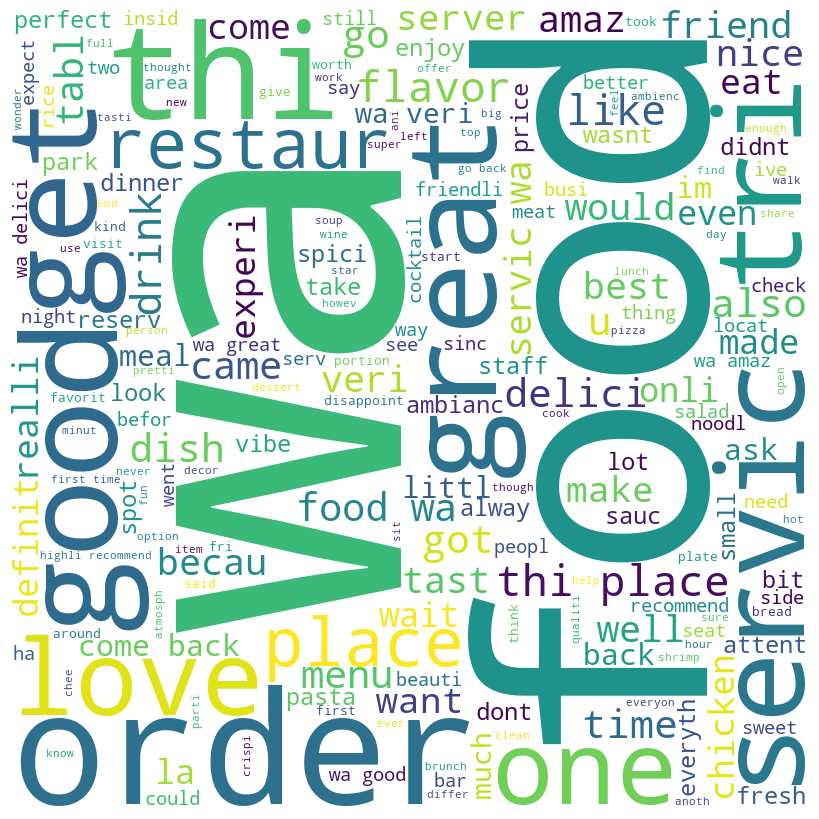

In [1160]:
from wordcloud import WordCloud
nltk.download('stopwords')

text = " ".join(x for x in dataframe["Comment"])
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords=STOPWORDS,
                min_font_size = 10).generate(text)

plt.figure(figsize = (8, 8), facecolor = "white")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

Векторизация текста

In [1161]:
vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, sublinear_tf=True, min_df=5)
data_vectorized = vectorizer.fit_transform(data_text)
data_toconcat = pd.DataFrame.sparse.from_spmatrix(data_vectorized)

data_toconcat.shape

(2371, 2296)

Добавление к исходной таблице полученных векторов и удаление исходных комментариев

In [1162]:
dataframe = pd.concat((dataframe, data_toconcat), axis=1)
dataframe = dataframe.drop(["Comment"], axis=1)
dataframe

,CommentDate,StarRating,Food Stands,Kebab,Wraps,Fast Food,Middle Eastern,Juice Bars & Smoothies,Diners,Barbeque,...,2286,2287,2288,2289,2290,2291,2292,2293,2294,2295
0,738779,4.4,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,738778,4.4,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,738770,4.4,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,738769,4.4,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,738768,4.4,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2366,738698,4.8,1,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2367,738678,4.8,1,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2368,738669,4.8,1,0,0,0,0,0,0,0,...,0.0,0.103032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2369,738660,4.8,1,0,0,0,0,0,0,0,...,0.0,0.061578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 5. Стандартизация

Для корректной работы алгоритмов выполним стандартизацию признаков

Стандартизация выполняется только над двумя признаками `CommentDate` и `StarRating`. Все остальные признаки имеют тип sparce, который не поддерживает математические операции(да и я не уверен что для таких данных нужна стандартизация)

In [1163]:
columns = ["CommentDate", "StarRating"] #, "$$", "$$$", "$$$$"] + list(styles)
dataframe[columns] = (dataframe[columns] - dataframe[columns].mean(axis=0))/dataframe[columns].std(axis=0)
dataframe[columns].describe()

,CommentDate,StarRating
count,2.371000e+03,2.371000e+03
mean,3.390287e-13,-8.271185e-16
std,1.000000e+00,1.000000e+00
min,-2.751360e+01,-2.574419e+00
25%,5.763093e-02,-6.497943e-01
50%,1.641085e-01,-8.252645e-03
75%,2.028276e-01,6.332890e-01
max,2.479999e-01,2.237143e+00


## 6. Разбиение данных на обучающую и тестовую выборки

Произведем разбиение в соотношении 70/30

In [1164]:
X = dataframe.drop("StarRating", axis=1)
X = X.to_numpy() # жалуется на sparce
y = dataframe["StarRating"]
X.shape, y.shape

((2371, 2433), (2371,))

In [1165]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1659, 2433), (712, 2433), (1659,), (712,))

## 7. Метод k-ближайших соседей

In [1166]:
from sklearn.neighbors import KNeighborsRegressor

kNN = KNeighborsRegressor(n_neighbors=10)
kNN.fit(X_train, y_train)
kNN.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 10,
 'p': 2,
 'weights': 'uniform'}

Ошибка на обучающей выборке:

In [1167]:
y_train_prediction = kNN.predict(X_train)
err_train = 1 - kNN.score(X_train, y_train)
err_train

0.1874496787021056

Ошибка на тестовой выборке:

In [1168]:
y_test_prediction = kNN.predict(X_test)
err_test = 1 - kNN.score(X_test, y_test)
err_test

0.3062560914994601

Попробуем подобрать оптимальное значение параметра количества соседей

## 8. Подбор оптимального количества ближайших соседей

In [1169]:
from sklearn.model_selection import GridSearchCV
nnb = [i for i in range(1, 50)]
knn = KNeighborsRegressor()

grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, y_train)

best_knn = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
best_knn, best_n_neighbors

(0.08878368096604272, 3)

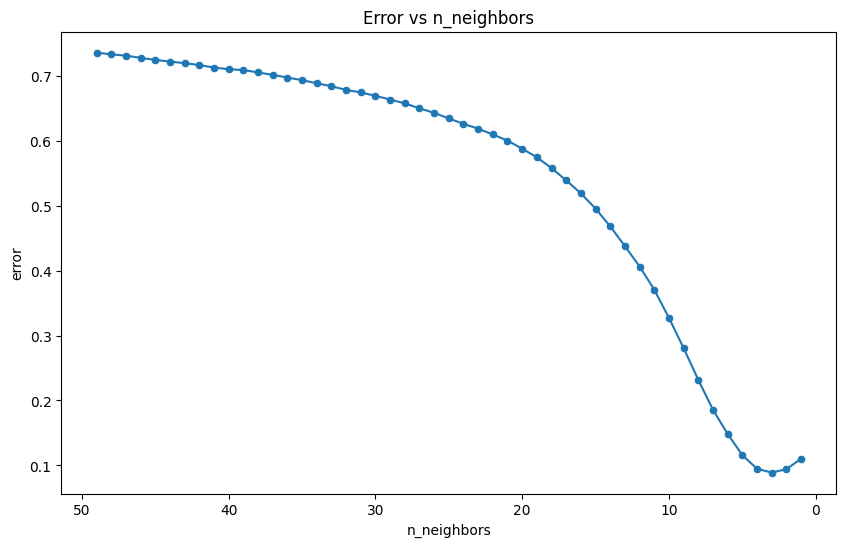

In [1170]:
results = grid.cv_results_
scores_mean = results['mean_test_score']

plt.figure(figsize=(10, 6))
sns.lineplot(x=nnb, y= 1 - scores_mean)
sns.scatterplot(x=nnb, y= 1 - scores_mean)
plt.xlabel('n_neighbors')
plt.ylabel('error')
plt.title('Error vs n_neighbors')
plt.gca().invert_xaxis()
plt.show()

Лучший результат показывает модель с количеством соседей равном 3. Видимо для предсказания нужна довольно сложная нелинейная модель.

## 9. Вычисление ошибок на обучающей и тестовой выборках

In [1171]:
kNN = KNeighborsRegressor(n_neighbors=2)
kNN.fit(X_train, y_train)
kNN.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 2,
 'p': 2,
 'weights': 'uniform'}

In [1172]:
y_train_prediction = kNN.predict(X_train)
err_train = 1 - kNN.score(X_train, y_train)
err_train

0.028463730307786372

In [1173]:
y_test_prediction = kNN.predict(X_test)
err_test = 1 - kNN.score(X_test, y_test)
err_test

0.1249428507383652

## 10. Другие регрессоры

#### Random Forest Regression

In [1174]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=25, max_depth=10, random_state=1)
forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=25, random_state=1)

Ошибка на обучающей выборке:

In [1175]:
y_train_prediction = forest.predict(X_train)
err_train = 1 - forest.score(X_train, y_train)
err_train

0.3726301835269048

Ошибка на тестовой выборке:

In [1176]:
y_test_prediction = forest.predict(X_test)
err_test = 1 - forest.score(X_test, y_test)
err_test

0.557382512504121

Подбор оптимальной глубины для деревьев

In [1177]:
from sklearn.model_selection import GridSearchCV
depths = [i for i in range(5, 100, 15)]
forest = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=1)

grid = GridSearchCV(forest, param_grid = {'max_depth': depths}, cv=10)
grid.fit(X_train, y_train)

best_forest = 1 - grid.best_score_
best_max_depth = grid.best_estimator_.max_depth
best_forest, best_max_depth

(0.36971871890617436, 80)

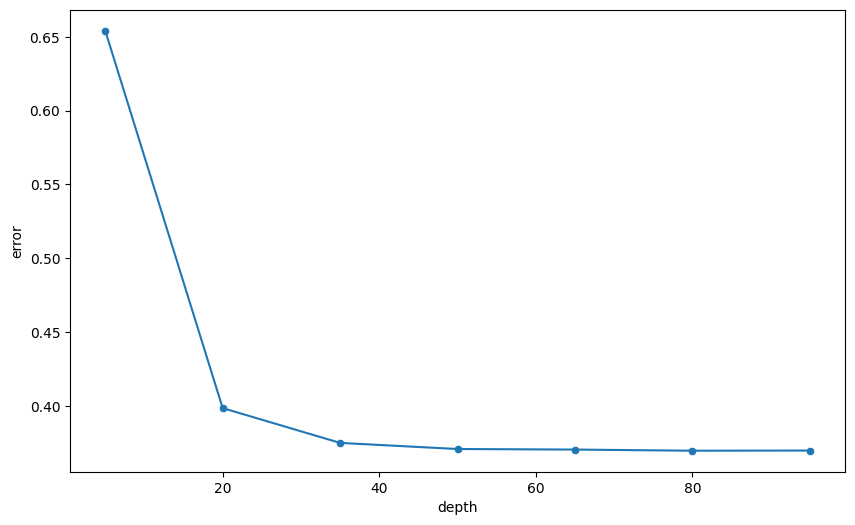

In [1178]:
results = grid.cv_results_
scores_mean = results['mean_test_score']

plt.figure(figsize=(10, 6))
sns.lineplot(x=depths, y= 1 - scores_mean)
sns.scatterplot(x=depths, y= 1 - scores_mean)
plt.xlabel('depth')
plt.ylabel('error')
plt.show()

Оптимальная глубина для деревьев равняется 80, но начиная с 50 изменения совсем минимальные

#### Линейная регрессия

In [1179]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
lr.coef_

array([-7.70772335e-14,  2.84234565e+00, -4.21265792e-01, ...,
       -3.91852220e-01,  5.81095466e-01, -1.07038933e+00])

In [1180]:
y_train_prediction = lr.predict(X_train)
err_train = 1 - lr.score(X_train, y_train)
err_train

0.0

Совершенно не могу понять как выходит ошибка 0.0 у линейной регрессии

In [1181]:
y_test_prediction = lr.predict(X_test)
r_squared = 1 - ( 1-lr.score(X, y) ) * ( len(y) - 1 ) / ( len(y) - X.shape[1] - 1 )
err_test = r_squared # скорректированный коэффициент детерминации
best_lr = err_test
best_lr

13.844248233616455

Совершенно не могу понять почему скорректированный коэффициент детерминации = 13

Скорее всего линейная регрессия не подходит для таких данных

### Результаты

In [1182]:
results = pd.DataFrame({
    "Model": ["KNN",
                   "RandomForest",
                   "LinearRegression"],
    "Error": [best_knn,
                   best_forest,
                   best_lr]})
results

,Model,Error
0,KNN,0.088784
1,RandomForest,0.369719
2,LinearRegression,13.844248


### 11. Несбалансированность классов

Задача регрессии

### 12. Коррелированные переменные

Исключил `Rank`, `RestaurantName`, `Address`, `NumberOfReviews` по причине высокой сложности модели и увеличения ошибки, возможно они сильно коррелируют с целевым признаком `StarRating`

## 13. Общий вывод

В данной практической работе по данным `Top 240 Recommended Restaurants in L.A. 2023` были обучены модели для предсказания рейтинга ресторана на основе текстовых и категориальных признаков. Для этого предварительно данные были обработаны: исключены пропущенные значения, закодированы категориальные признаки. Для использования в модели комментариев удалили излишние символы, произвели стемминг и векторизацию. Среди обученных моделей: kNN, RandomForest и Linear Regression, лучший результат показал метод ближайших соседей с гиперпараметром кол-ва соседей = 3.<br>
KNN_error = 0.088784.<br>
Полученные модели имеют неплохую точность. Исключением оказалась модель линейной регресии, которая выдала совсем неадекватные значения, которые можно объянить лишь тем, что зависимость целевого признака от предикторов совсем нелинейна (либо я где то накосячил). Стоит также принять во внимание, что оценка может быть субъективна, и не зависеть от представленных в таблице факторов. 